# Sampling, Bias, and Community Structure in Real Networks

## Part A — Sampling and Bias in Network Analysis (15 pts)

Goal: Investigate how different sampling methods can change the observed structure of a social network.

In [145]:
import networkx as nx
import random
from tabulate import tabulate
import matplotlib.pyplot as plt

G_fb = nx.read_edgelist("facebook_combined.txt", nodetype=int)

### A1 – Create Two Samples (6 pts)

In [146]:
# 1. Random Sample – Randomly select 250 nodes.
nodes = random.sample(sorted(G_fb.nodes()), 250)
G_random = G_fb.subgraph(nodes).copy()

# 2. Ego-Centered Sample – Pick a node with degree > 50 and build its 1.5-degree ego network.
center = max(G_fb, key=lambda n: G_fb.degree(n))
G_ego = nx.ego_graph(G_fb, center, radius=1)
print(
    tabulate(
        [
            ["Random", G_random.number_of_nodes(), G_random.number_of_edges()],
            ["Ego", G_ego.number_of_nodes(), G_ego.number_of_edges()],
        ],
        headers=["Sample", "# Nodes", "# Edges"]
    )
)

Sample      # Nodes    # Edges
--------  ---------  ---------
Random          250        394
Ego            1046      27795


## A2 – Compute and Visualize Metrics (6 pts)

For each sample (`G_random`, `G_ego`):

- Compute Average Clustering Coefficient (C)
- Compute Average Shortest Path Length (L) (on largest component if needed)
- Find Maximum Degree (Max k)

### 1. Table of Metrics

In [147]:
print(
    tabulate(
        [
            [
                "Random",
                round(nx.average_clustering(G_random), 2),
                round(
                    nx.average_shortest_path_length(
                        G_random.subgraph(
                            max(nx.connected_components(G_random), key=len)
                        )
                    ),
                    2,
                ),
                max(G_random.degree, key=lambda x: x[1])[1],
            ],
            [
                "Ego",
                round(nx.average_clustering(G_ego), 2),
                round(
                    nx.average_shortest_path_length(
                        G_ego.subgraph(
                            max(nx.connected_components(G_ego), key=len)
                        )
                    ),
                    2,
                ),
                max(G_ego.degree, key=lambda x: x[1])[1],
            ],
        ],
        headers=["Sample", "Avg Clustering (C)", "Avg Path (L)", "Max Degree"]
    )
)

Sample      Avg Clustering (C)    Avg Path (L)    Max Degree
--------  --------------------  --------------  ------------
Random                    0.29            1.96            64
Ego                       0.58            1.95          1045


### 2. Two degree distribution plots (log–log axes)

Each plot must include a title, axis labels (“Degree (k)” and “Count of Nodes”)

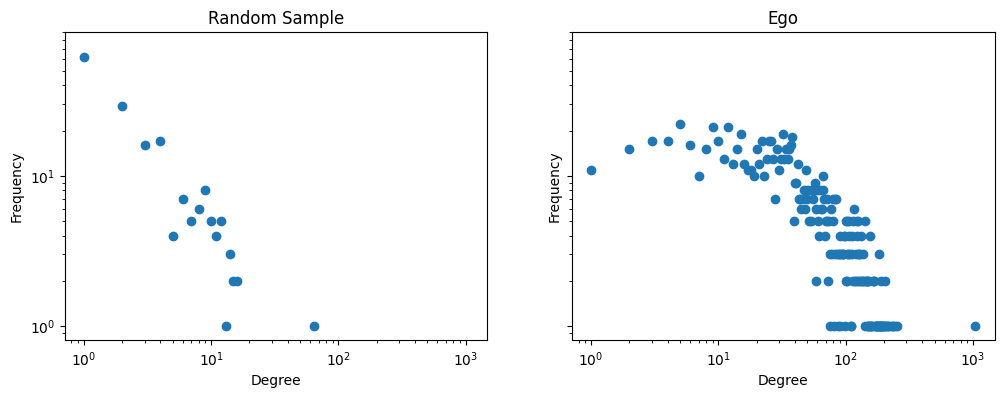

In [148]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)

axes[0].set_title("Random Sample")
axes[0].set_xlabel("Degree")
axes[0].set_ylabel("Frequency")
degree_freq = nx.degree_histogram(G_random)
degrees = range(len(degree_freq))
axes[0].loglog(degrees, degree_freq, "o")

axes[1].set_title("Ego")
axes[1].set_xlabel("Degree")
axes[1].set_ylabel("Frequency")
degree_freq = nx.degree_histogram(G_ego)
degrees = range(len(degree_freq))
axes[1].loglog(degrees, degree_freq, "o")
plt.show()

## A3 – Reflection (3 pts)

Discuss:

- How the random and ego-centered samples differ in clustering and degree patterns
- What type of bias the ego-sampling method introduces
- What the differences imply about sampling in real network data

### Part A Reflection.

The random sample subgraph of the FB combined graph differ significantly from
the ego subgraph because the ego subgraph is directly selecting for the node 
with highest degree centrality. This skews both the number of nodes and number 
of edges because the ego node has an unsually high number of neighbors. Another 
sampling bias that is introduced when using the ego graph is that the degree 
distribution is pushed higher. We see that the random sample nicely follows the 
scale free trend, producing a strong linear relationship on a log-log plot. 
However, the degree distribution of the ego graph shows that there are more
nodes that have a relatively high degree. This is a result of social prestige 
and preferential attatchment. Popular nodes tend to stick by other popular nodes,
thus the ego graph of a popular node will have, on average, higher degrees. 

## Part B — Community Detection and Modularity (15 pts)

**Goal:** Identify and compare community structure across model networks and a real social network.

### B1 – Run Community Detection (8 pts)

Compute the following for each graph (ER, WS, BA, Facebook):

- Number of communities
- Modularity Q
- Size of largest community (number of nodes)
- Also include one **visualization** showing a few detected communities in different colors.

In [149]:
n = len(G_fb)
m = len(G_fb.edges)
G_er = nx.erdos_renyi_graph(n, (2*m)/(n*(n-1)))
G_ws = nx.watts_strogatz_graph(n, 10, 0.1)
G_ba = nx.barabasi_albert_graph(n, 2)

In [150]:
# TODO: can be cleanly done with pandas or other data manipulation tool.
networks = {
    "ER": G_er,
    "WS": G_ws,
    "BA": G_ba,
    "Facebook": G_fb,
}

communities = {
    name: nx.community.greedy_modularity_communities(G) 
    for name, G in networks.items()
}

modularities = {
    name: nx.community.modularity(networks[name], comm) 
    for name, comm in communities.items()
}

In [151]:
headers = ["Network", "# Communities", "Modularity (Q)", "Largest Community Size"]
tabs = []
for name, G, community, modularity in zip(
    networks.keys(), 
    networks.values(), 
    communities.values(), 
    modularities.values()
):
    tab = [name, len(community), modularity, max(len(com) for com in community)]
    tabs.append(tab)

print(tabulate(tabs, headers))

Network      # Communities    Modularity (Q)    Largest Community Size
---------  ---------------  ----------------  ------------------------
ER                       5          0.118449                      1511
WS                       5          0.670752                      1102
BA                      30          0.532359                       327
Facebook                13          0.777378                       983


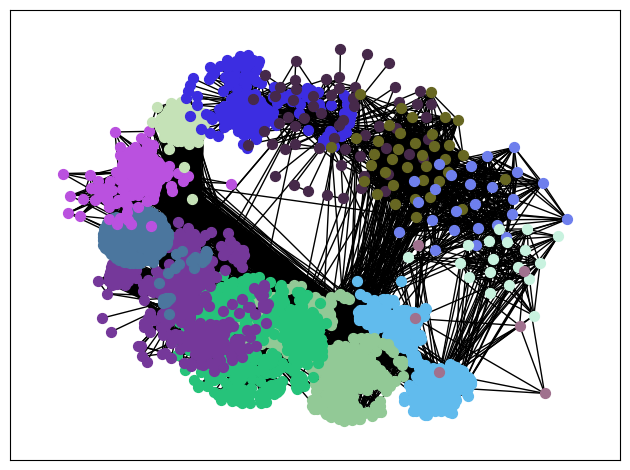

In [152]:
# Visuallize Facebook network communities
def generate_n_random_hex_colors(n):
    """
    Generates a list of N random hexadecimal color codes.
    Each color is represented as a string in the format '#RRGGBB'.
    """
    colors = []
    for _ in range(n):
        # Generate a random integer between 0 and 0xFFFFFF (inclusive)
        # and format it as a 6-digit hexadecimal string.
        hex_color = '#%06x' % random.randint(0, 0xFFFFFF)
        colors.append(hex_color)
    return colors


# Compute positions for the node clusters as if they were themselves nodes in a
# supergraph using a larger scale factor
supergraph = nx.cycle_graph(len(communities["Facebook"]))
superpos = nx.spring_layout(supergraph, scale=2, seed=429)

# Use the "supernode" positions as the center of each node cluster
centers = list(superpos.values())
pos = {}
for center, comm in zip(centers, communities["Facebook"]):
    pos.update(nx.spring_layout(nx.subgraph(G_fb, comm), center=center, seed=1430))

# Nodes colored by cluster
for nodes, clr in zip(communities["Facebook"], generate_n_random_hex_colors(len(communities["Facebook"]))):
    nx.draw_networkx_nodes(G_fb, pos=pos, nodelist=nodes, node_color=clr, node_size=50)
nx.draw_networkx_edges(G_fb, pos=pos)

plt.tight_layout()
plt.show()

## B2 – Quantitative Comparison and Summary (5 pts)

Use the results from B1 to create the following **comparative metrics and visuals**:

### Summary Table

In [153]:
clusterings = {
    name: nx.average_clustering(network) 
    for name, network in networks.items()
}

tabs = []
headers = ["Network", "Avg Community Size", "Avg Clustering (C)"]
for name, network, community, clustering in zip(
    networks.keys(),
    networks.values(),
    communities.values(),
    clusterings.values()
):
    tab = [name, sum(len(c) for c in community)/len(community), clustering]
    tabs.append(tab)

print(tabulate(tabs, headers))
    

Network      Avg Community Size    Avg Clustering (C)
---------  --------------------  --------------------
ER                      807.8              0.0107826
WS                      807.8              0.486018
BA                      134.633            0.00810017
Facebook                310.692            0.605547


### Bar Chart

Compare *Modularity Q* across networks.

- x-axis: Network type
- y-axis: Modularity Q
- Title: "Comparison of Modularity Across Networks"

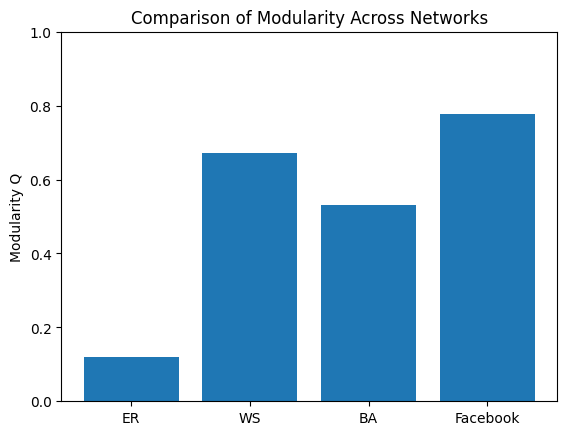

In [156]:
plt.title("Comparison of Modularity Across Networks")
x = list(modularities.keys())
y = list(modularities.values())
plt.bar(x, y)
plt.ylabel("Modularity Q")
plt.ylim((0, 1))
plt.show()

### Scatter Plot

- x-axis: Average CLustering
- y-axis: Modularity Q
- Title: "Custering vs. Modularity Relationship"

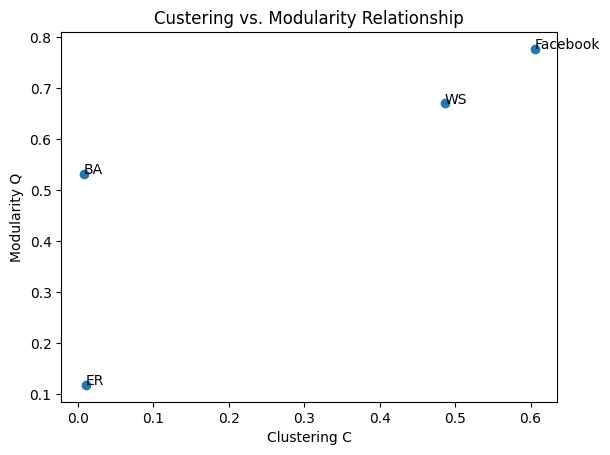

In [ ]:
plt.title("Custering vs. Modularity Relationship")

x = list(clusterings.values())
plt.xlabel("Clustering C")

y = list(modularities.values())
plt.ylabel("Modularity Q")

labels = list(networks.keys())
plt.scatter(x, y)
for x1, y1, label in zip(x, y, labels):
    plt.text(x1, y1, label)
    
plt.show()

### Short Quantitative Summary (4–5 sentences)

First, wee see that by most metrics, the WS model best fits 
our actual Facebook data. This is because the WS model is designed to 
mimic the clustering and "small world" phenomenon in social networks. The 
metrics that are most similar are Modularity $Q$ and Average CLustering $C$. 

*Note that our modularity is computed based on the community found via Greedy 
Modularity search. Different community generation algorithms may yield different 
results.*

This shows that WS graphs form strong and easily defined communities, and that 
they cluster in similar ways to real social networks. 

Looking at the ER graph, we see that by all metrics, it fails miserably. BA
graphs perform marginally better because it decently mimics the community 
structure of social networks through its formation of hubs, however it fails 
to account for the clustering of social groups.

## B3 – Reflection (2 pts)

### Part B Reflection.

Discuss what your quantitative results suggest about how real social networks differ from idealized models and how strong community structure might influence information flow or diffusion.

Our quantitative results suggests that real social networks differ greatly from 
idealized models. We saw that of the idealized models, WS graphs behave most 
similarly to real social networks. However, WS models, at least with our 
specific parameters, still do not have the same levels of clustering
and community definition, as seen by chart B2.3. When considering diffusion 
dynamics in our networks, models that generate extremely large hubs tend to 
overestimate the speed of diffusion in SI and SIR models. On the other hand, 
the applying the threshold model to any of our graphs would underestimate the 
speed of diffusion because all of our models underestimate clustering. Clustering
is what drives diffusion in the threshold model. 